## Datashading a 1-billion-point Open Street Map database

The [osm.ipynb](https://anaconda.org/jbednar/osm) example shows how to use Dask's out of core support for working with datasets larger than will fit in memory.  Here, we consider the largest dataset that will fit comfortably on a 16GB machine, namely 1 billion x,y points (at 32-bit float resolution). You can download it from our site:

http://s3.amazonaws.com/datashader-data/osm-1billion.parq.zip

and unzip it into the `./data/` directory, but because of its size it's not downloaded with the other examples by default, and please try to limit the number of times you download it so that we can continue making it available.


**NOTE:**  This dataset is also explorable through the Datashader example dashboard. From inside the examples directory, run: `DS_DATASET=osm-1b panel serve --show dashboard.ipynb`

The data is taken from Open Street Map's (OSM) [bulk GPS point data](https://blog.openstreetmap.org/2012/04/01/bulk-gps-point-data/). The data was collected by OSM contributors' GPS devices, and was provided as a CSV file of `latitude,longitude` coordinates. The data was downloaded from their website, extracted, converted to use positions in Web Mercator format using `datashader.utils.lnglat_to_meters()`, sorted using [spacial indexing](http://datashader.org/user_guide/2_Points.html#Spatial-indexing), and then stored in a [parquet](https://github.com/dask/fastparquet) file for [faster disk access](https://github.com/bokeh/datashader/issues/129#issuecomment-300515690). As usual, loading it into memory will be the most time-consuming step, by far:

<style>.container { width:100% !important; }</style>

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader import spatial

from colorcet import fire

In [2]:
%%time
df = spatial.read_parquet('./data/osm-1billion.parq')
df = df.persist()

CPU times: user 27.8 s, sys: 19.8 s, total: 47.7 s
Wall time: 19 s


In [3]:
print(len(df))
df.head()

1000050363


x           y
0 -16274360.0 -17538778.0
1 -16408889.0 -16618700.0
2 -16246231.0 -16106805.0
3 -19098164.0 -14783157.0
4 -17811662.0 -13948767.0

### Aggregation

To visualize this data, we first create a canvas to provide pixel-shaped bins in which points can be aggregated, and then aggregate the data to produce a fixed-size aggregate array. For data already in memory, this aggregation is the only expensive step, because it requires reading every point in the dataset. For interactive use we are most interested in the performance for a *second* aggregation, after all of the components and data are in memory and the user is interacting with a plot dynamically.  So let's first do a dry run, which will be slightly slower, then do the full aggregation to show what performance can be expected during interactive use with a billion datapoints:

In [4]:
bound = 20026376.39
bounds = dict(x_range = (-bound, bound), y_range = (int(-bound*0.4), int(bound*0.6)))
plot_width = 900
plot_height = int(plot_width*0.5)

In [5]:
%%time
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds)
agg2=cvs.points(df, 'x', 'y', ds.count())

CPU times: user 11.9 s, sys: 18.4 s, total: 30.2 s
Wall time: 6.06 s


In [6]:
%%time
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, **bounds)
agg = cvs.points(df, 'x', 'y', ds.count())

CPU times: user 10.3 s, sys: 192 ms, total: 10.5 s
Wall time: 1.98 s


As you can see, once everything has been loaded, aggregating this billion-point dataset takes a couple of seconds on a 16GB Macbook laptop.  The remaining steps for display complete in milliseconds, so those times are not shown below.


### Transfer Function

To actually see the data, we need to render an image of the aggregate array.  Let's map small (but nonzero) counts to light blue, the largest counts to dark blue, and interpolate according to a logarithmic function in between:

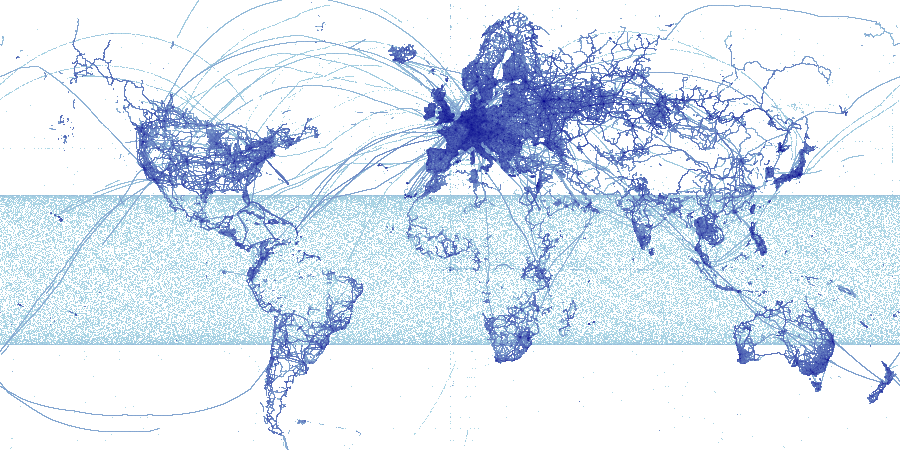

In [7]:
tf.shade(agg, cmap=["lightblue", "darkblue"], how='log')

There's some odd, low-count, nearly-uniform noise going on in the tropics. It's worth trying to figure out what that could be, but for now we can filter it out quickly from the aggregated data using the `where` method from xarray.  We'll also switch to the parameter-free histogram equalization method for mapping to colors using various colormaps:

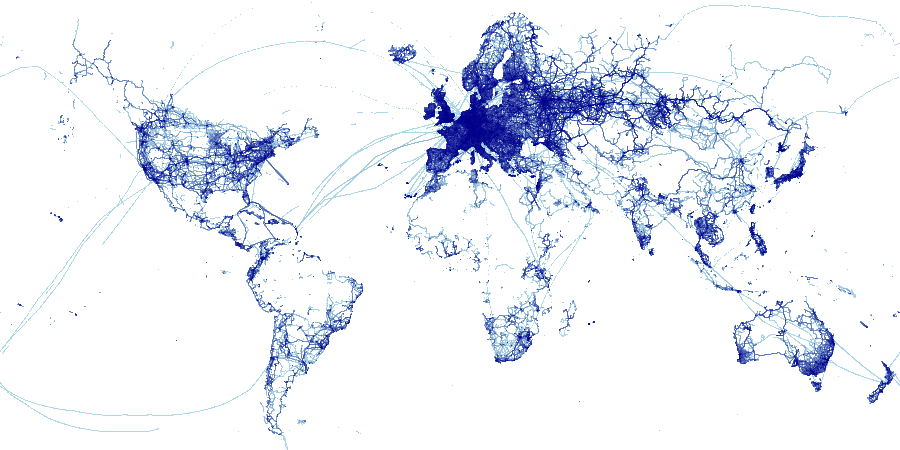

In [8]:
tf.shade(agg.where(agg > 15), cmap=["lightblue", "darkblue"])

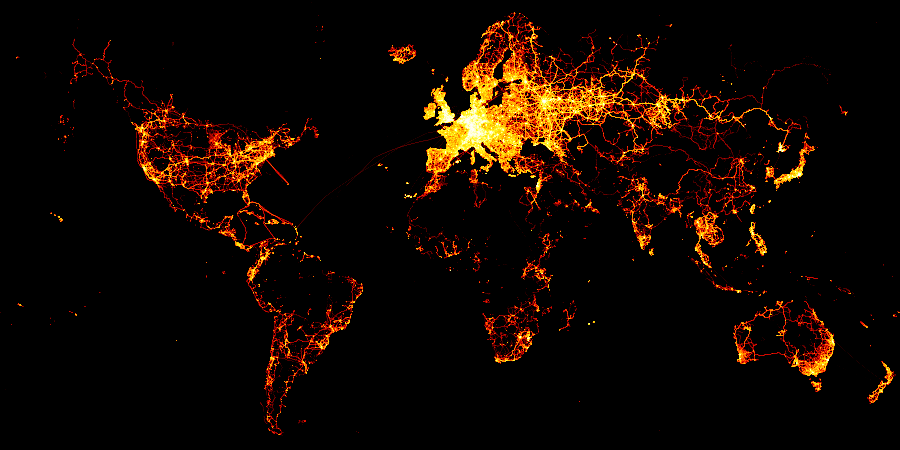

In [9]:
tf.set_background(tf.shade(agg.where(agg > 15), cmap=fire),"black")

The result covers the most-populated areas of the globe, with Europe apparently having particularly many OpenStreetMap contributors. The long great-circle paths visible on the white background are presumably flight or boat trips, from devices that log their GPS coordinates more than 15 times during the space of one pixel in this plot (or else they would have been eliminated by the `where` call).

### Interactive plotting

As long as the data fits into RAM on your machine, performance should be high enough to explore the data interactively, with only a brief pause after zooming or panning to a new region of the data space.  Performance should be much higher when you are zoomed in, thanks to the spatially sorted data structure used here; if you use a regular Pandas or Dask dataframe it will need to iterate through the entire dataset on each zoom rather than only considering a subset as used here.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
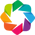

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In [10]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, dynspread
hv.extension('bokeh')

rgb_opts = opts.RGB(width=plot_width,height=plot_height, xaxis=None, yaxis=None, bgcolor="black")
points = hv.Points(df, ['x', 'y']).redim.range(x=bounds["x_range"],y=bounds["y_range"])
rgb = dynspread(datashade(points, cmap=["darkblue", "lightcyan"], width=plot_width,height=plot_height))
rgb.opts(rgb_opts)

Here the plot will be refreshed only if you are running the notebook with a live Python server; for static notebooks like those at anaconda.org you can zoom in but the plot will never be re-rendered at the higher resolution needed at that zoom level.